In [14]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.image import PatchExtractor
from skimage.feature import hog
from skimage.transform import resize

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"nikhilgupta2005","key":"0671963a83428554a31f4abb4d7a12b1"}'}

In [4]:
import os
import kagglehub

path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

print("Path to dataset files:", path)

print("Dataset contents:", os.listdir(path))


Path to dataset files: /kaggle/input/chest-xray-pneumonia
Dataset contents: ['chest_xray']


In [5]:
base_dir =  "/kaggle/input/chest-xray-pneumonia/chest_xray"
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

print("Base Directory:", base_dir)
print("Train Directory:", train_dir)
print("Validation Directory:", val_dir)
print("Test Directory:", test_dir)

Base Directory: /kaggle/input/chest-xray-pneumonia/chest_xray
Train Directory: /kaggle/input/chest-xray-pneumonia/chest_xray/train
Validation Directory: /kaggle/input/chest-xray-pneumonia/chest_xray/val
Test Directory: /kaggle/input/chest-xray-pneumonia/chest_xray/test


In [13]:
def extract_features(img_path, img_width=224, img_height=224):
    try:
        # Load image and convert to grayscale
        img = Image.open(img_path).convert('L')
        img = img.resize((img_width, img_height))
        img_array = np.array(img)

        # Extract HOG features
        hog_features = hog(img_array, orientations=9, pixels_per_cell=(16, 16),
                         cells_per_block=(2, 2), feature_vector=True)

        return hog_features
    except Exception as e:
        print(f"Error processing {img_path}: {e}")
        return None

In [6]:
# Function to load and prepare data
def prepare_data(data_dir):
    normal_dir = os.path.join(data_dir, 'NORMAL')
    pneumonia_dir = os.path.join(data_dir, 'PNEUMONIA')

    features = []
    labels = []

    # Load NORMAL images
    normal_images = [os.path.join(normal_dir, img) for img in os.listdir(normal_dir) if img.endswith(('.jpeg', '.jpg', '.png'))]
    for img_path in tqdm(normal_images, desc="Processing NORMAL images"):
        feature = extract_features(img_path)
        if feature is not None:
            features.append(feature)
            labels.append(0)  # 0 for NORMAL

    # Load PNEUMONIA images
    pneumonia_images = [os.path.join(pneumonia_dir, img) for img in os.listdir(pneumonia_dir) if img.endswith(('.jpeg', '.jpg', '.png'))]
    for img_path in tqdm(pneumonia_images[:len(normal_images)], desc="Processing PNEUMONIA images"):  # Balancing data
        feature = extract_features(img_path)
        if feature is not None:
            features.append(feature)
            labels.append(1)  # 1 for PNEUMONIA

    return np.array(features), np.array(labels)

# Prepare training and testing data
print("Preparing training data...")
X_train, y_train = prepare_data(train_dir)
print("Preparing testing data...")
X_test, y_test = prepare_data(test_dir)

Preparing training data...


Processing PNEUMONIA images: 100%|██████████| 1341/1341 [00:35<00:00, 37.80it/s]


Preparing testing data...


Processing PNEUMONIA images: 100%|██████████| 234/234 [00:04<00:00, 48.80it/s]


In [7]:
from sklearn.linear_model import LogisticRegression

img_width, img_height = 224, 224

lr_model = LogisticRegression(C=1.0, max_iter=1000, solver='liblinear', random_state=42)
lr_model.fit(X_train, y_train)

# Make predictions
lr_pred = lr_model.predict(X_test)

# Evaluate the model
lr_accuracy = accuracy_score(y_test, lr_pred)
print(f"Logistic Regression Accuracy: {lr_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, lr_pred, target_names=['NORMAL', 'PNEUMONIA']))

Logistic Regression Accuracy: 0.7415

Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.97      0.50      0.66       234
   PNEUMONIA       0.66      0.99      0.79       234

    accuracy                           0.74       468
   macro avg       0.82      0.74      0.72       468
weighted avg       0.82      0.74      0.72       468



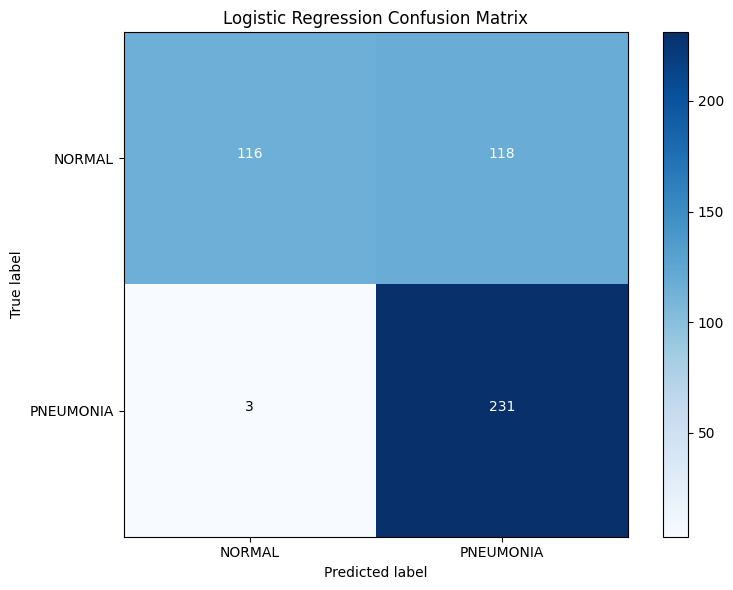

In [8]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, lr_pred)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Logistic Regression Confusion Matrix')
plt.colorbar()
plt.xticks([0, 1], ['NORMAL', 'PNEUMONIA'])
plt.yticks([0, 1], ['NORMAL', 'PNEUMONIA'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
for i in range(2):
    for j in range(2):
        plt.text(j, i, str(cm[i, j]), horizontalalignment="center", color="white" if cm[i, j] > cm.max() / 2 else "black")
plt.tight_layout()
plt.show()

In [9]:
print("\n===== Random Forest Model =====")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

# Make predictions
rf_pred = rf_model.predict(X_test)

# Evaluate the model
rf_accuracy = accuracy_score(y_test, rf_pred)
print(f"Random Forest Accuracy: {rf_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, rf_pred, target_names=['NORMAL', 'PNEUMONIA']))


===== Random Forest Model =====
Random Forest Accuracy: 0.7906

Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.95      0.62      0.75       234
   PNEUMONIA       0.72      0.97      0.82       234

    accuracy                           0.79       468
   macro avg       0.83      0.79      0.78       468
weighted avg       0.83      0.79      0.78       468



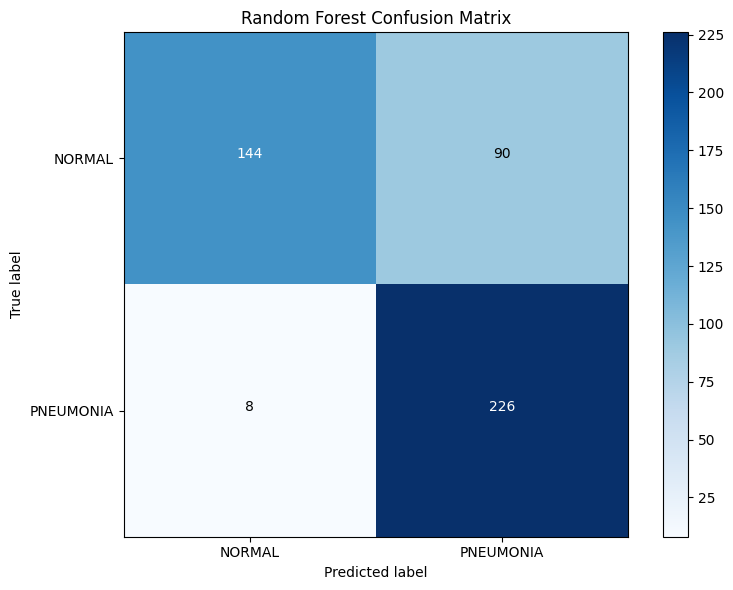

In [10]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, rf_pred)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Random Forest Confusion Matrix')
plt.colorbar()
plt.xticks([0, 1], ['NORMAL', 'PNEUMONIA'])
plt.yticks([0, 1], ['NORMAL', 'PNEUMONIA'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
for i in range(2):
    for j in range(2):
        plt.text(j, i, str(cm[i, j]), horizontalalignment="center", color="white" if cm[i, j] > cm.max() / 2 else "black")
plt.tight_layout()
plt.show()

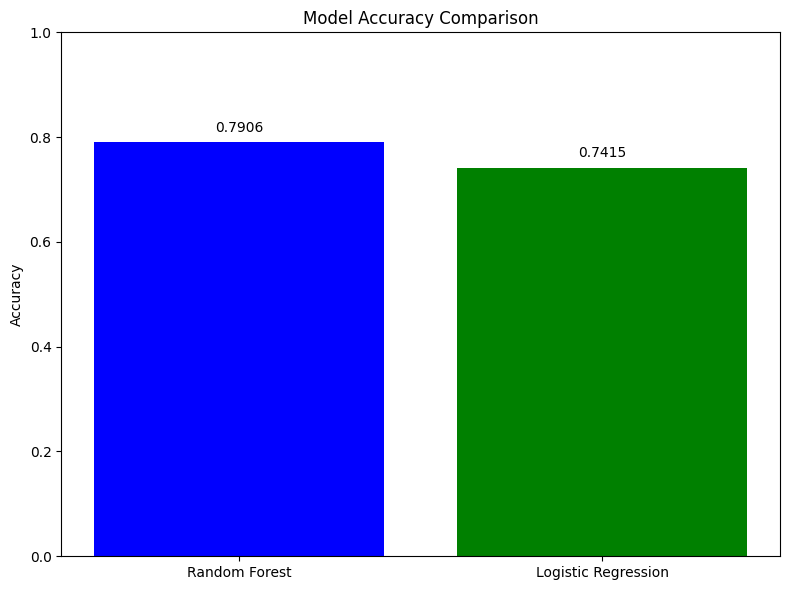

In [11]:
models = ['Random Forest', 'Logistic Regression']
accuracies = [rf_accuracy, lr_accuracy]

plt.figure(figsize=(8, 6))
plt.bar(models, accuracies, color=['blue', 'green'])
plt.ylim(0, 1.0)
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.02, f'{v:.4f}', ha='center')
plt.tight_layout()
plt.show()

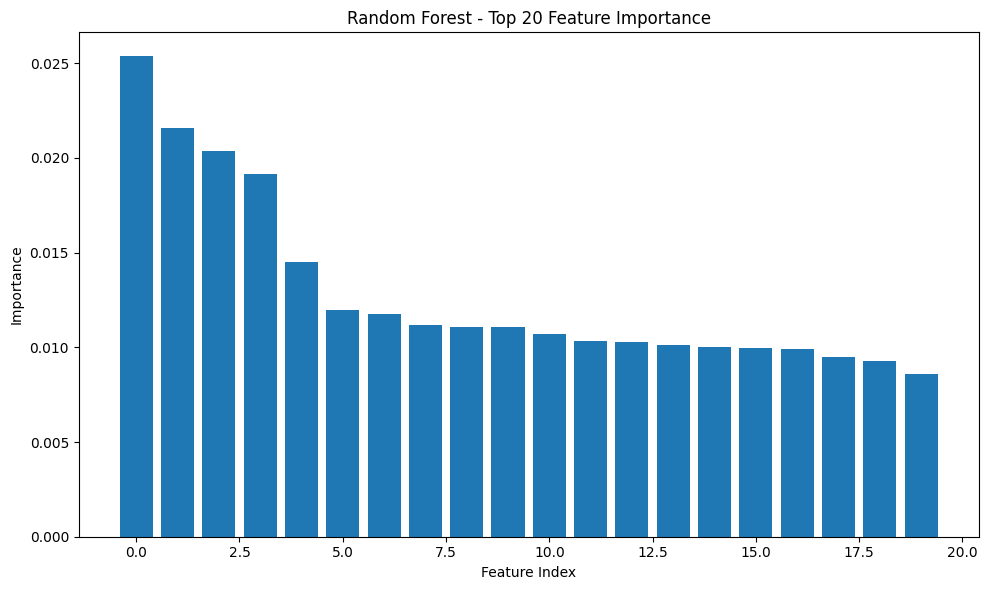

In [15]:
feature_importance = pd.Series(rf_model.feature_importances_, name='Importance')
feature_importance = feature_importance.sort_values(ascending=False)
top_features = feature_importance.head(20)

plt.figure(figsize=(10, 6))
plt.bar(range(len(top_features)), top_features.values)
plt.title('Random Forest - Top 20 Feature Importance')
plt.xlabel('Feature Index')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()
